In [31]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# PriorVAE reimplementation

For a 1D GP

In [32]:
from jax import random
import jax.numpy as jnp

import time




# Numpyro
import numpyro
import numpyro.distributions as dist
from numpyro import optim
from numpyro.infer import SVI, Trace_ELBO, MCMC, NUTS, init_to_median, Predictive

numpyro.set_host_device_count(3)

In [33]:
from reusable.kernels import esq_kernel

args = {
    # GP prior configuration
    "n": 100,
    "gp_kernel": esq_kernel,
    "rng_key": random.PRNGKey(2),
}
args.update(
    {  # so we can use the definition of n to define x
        "x": jnp.arange(0, 1, 1 / args["n"]),
        # VAE configuration
        "hidden_dim1": 35,
        "hidden_dim2": 32,
        "latent_dim": 30,
        "vae_var": 0.1,
        # learning
        "num_epochs": 250,
        "learning_rate": 1.0e-3,
        "batch_size": 400,
        "train_num_batches": 50,
        "test_num_batches": 2,
        # MCMC parameters
        "num_warmup": 1000,
        "num_samples": 1000,
        "thinning": 1,
        "num_chains": 3,
        "leaky_relu": True,
        "pretrained_vae": False,
        "pregenerated_data": False,
        "length_prior_choice": "invgamma",
        "length_prior_arguments": {"concentration": 4.0, "rate": 1.0},
        "variance_prior_choice": "gamma",
        "variance_prior_arguments": {"concentration": 20.0, "rate": 2.0},
    }
)

rng_key, _ = random.split(random.PRNGKey(4))

from reusable.gp import BuildGP

gp = gp = BuildGP(
    args["gp_kernel"],
    noise=False,
    length_prior_choice=args["length_prior_choice"],
    length_prior_args=args["length_prior_arguments"],
    variance_prior_choice=args["variance_prior_choice"],
    variance_prior_args=args["variance_prior_arguments"],
)


### Examples of priors to encode

## SVI to learn VAE parameters

Starting, need 20000
Looped: gen 1000/20000 , elapsed: 3.1642744541168213, last batch in 3.1642744541168213
Looped: gen 1000/19000 , elapsed: 5.3633387088775635, last batch in 2.199064254760742
Looped: gen 1000/18000 , elapsed: 7.172151327133179, last batch in 1.8088126182556152
Looped: gen 1000/17000 , elapsed: 9.051541328430176, last batch in 1.879390001296997
Looped: gen 1000/16000 , elapsed: 10.999409437179565, last batch in 1.9478681087493896
Looped: gen 1000/15000 , elapsed: 12.994595766067505, last batch in 1.9951863288879395
Looped: gen 1000/14000 , elapsed: 14.70647406578064, last batch in 1.7118782997131348
Looped: gen 1000/13000 , elapsed: 16.447983264923096, last batch in 1.741509199142456
Looped: gen 1000/12000 , elapsed: 18.165571689605713, last batch in 1.7175884246826172
Looped: gen 1000/11000 , elapsed: 20.003174781799316, last batch in 1.8376030921936035
Looped: gen 1000/10000 , elapsed: 21.687090635299683, last batch in 1.6839158535003662
Looped: gen 1000/9000 , elap

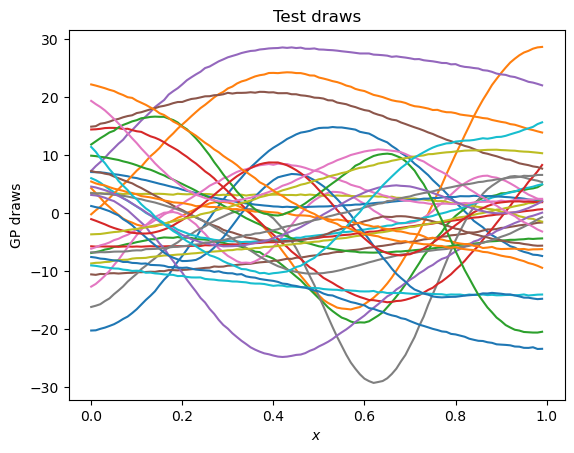

In [34]:
from reusable.util import save_datasets, gen_file_name, load_datasets

if not args["pretrained_vae"] and not args["pregenerated_data"]:
    from reusable.data import gen_gp_batches

    
    rng_key, rng_key_train, rng_key_test = random.split(rng_key, 3)
    
    train_draws = gen_gp_batches(args["x"], gp, args["gp_kernel"], args["train_num_batches"], args["batch_size"], rng_key_train)
    test_draws = gen_gp_batches(args["x"], gp, args["gp_kernel"], 1, args["test_num_batches"]* args["batch_size"], rng_key_test)
    

    save_datasets("02", gen_file_name("02", args, data_only=True), train_draws, test_draws)

elif args["pregenerated_data"]:

    train_draws, test_draws = load_datasets("02", gen_file_name("02", args, data_only=True))


if not args["pretrained_vae"]:
    from plotting.plots import plot_draws

    plot_draws(train_draws[4], args["x"], "Test draws", "GP draws")

In [13]:
from reusable.vae import VAE
from reusable.train_nn import SimpleTrainState
import optax

rng_key, rng_key_init, rng_key_train = random.split(rng_key, 3)

module = VAE(
    hidden_dim1=args["hidden_dim1"],
    hidden_dim2=args["hidden_dim2"],
    latent_dim=args["latent_dim"],
    out_dim=args["n"],
    conditional=False,
    leaky = args["leaky_relu"]
)
params = module.init(rng_key, jnp.ones((args["n"],)))["params"]  # initialize parameters by passing a template input
tx = optax.adam(args["learning_rate"])
state = SimpleTrainState.create(apply_fn=module.apply, params=params, tx=tx, key = rng_key_init)


epoch: 0, test_loss: 0.21761870384216309, train_loss: 0.8347914814949036
epoch: 5, test_loss: 0.2077263593673706, train_loss: 0.7644405364990234
epoch: 10, test_loss: 0.22187258303165436, train_loss: 0.8509131073951721
epoch: 15, test_loss: 0.22020336985588074, train_loss: 0.7662001848220825
epoch: 20, test_loss: 0.20784969627857208, train_loss: 0.8308127522468567
epoch: 25, test_loss: 0.22171436250209808, train_loss: 0.8332642912864685
epoch: 30, test_loss: 0.2193121612071991, train_loss: 0.8274418711662292
epoch: 35, test_loss: 0.24619115889072418, train_loss: 0.7715340256690979
epoch: 40, test_loss: 0.24412386119365692, train_loss: 0.8323318362236023
epoch: 45, test_loss: 0.2504521906375885, train_loss: 0.8456869721412659
epoch: 50, test_loss: 0.25122785568237305, train_loss: 0.8800434470176697
epoch: 55, test_loss: 0.24861319363117218, train_loss: 0.8219423890113831
epoch: 60, test_loss: 0.26454946398735046, train_loss: 0.9463383555412292
epoch: 65, test_loss: 0.2620887756347656, t

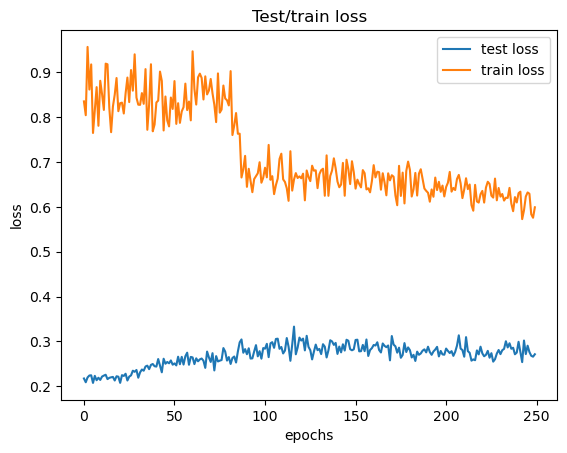

In [24]:
from plotting.plots import plot_training

from reusable.loss import combo_loss, RCL, KLD

rng_key, rng_key_shuffle = random.split(rng_key, 2)

if not args["pretrained_vae"]:
    from reusable.train_nn import run_training_shuffle



    state, metrics_history = run_training_shuffle(
            combo_loss(RCL, KLD), None, args["num_epochs"], train_draws, test_draws[0], state, rng_key_shuffle
        )


    plot_training(metrics_history["test_loss"], metrics_history["train_loss"], "Test/train loss", note="loss")


### Training progress

comment 09/02/2023: why is there a shelf in the loss?, also, why is our test loss so closer to train loss?

In [25]:
from reusable.util import gen_file_name, save_training, load_training_state, get_decoder_params


if not args["pretrained_vae"]:
    save_training("02", gen_file_name("02", args), state, metrics_history )

if args["pretrained_vae"]:
    state = load_training_state("02", gen_file_name("02", args), state)

    
args["decoder_params"] = get_decoder_params(state) 
   

Saved learnt_models/02/02__100_400_50_2_invgamma_4.0~1.0_gamma_20.0~2.0_100_35_32_30_0.1_True_250_0.001_400_50__.state
Saved learnt_models/02/02__100_400_50_2_invgamma_4.0~1.0_gamma_20.0~2.0_100_35_32_30_0.1_True_250_0.001_400_50__.hist


## Demonstrations

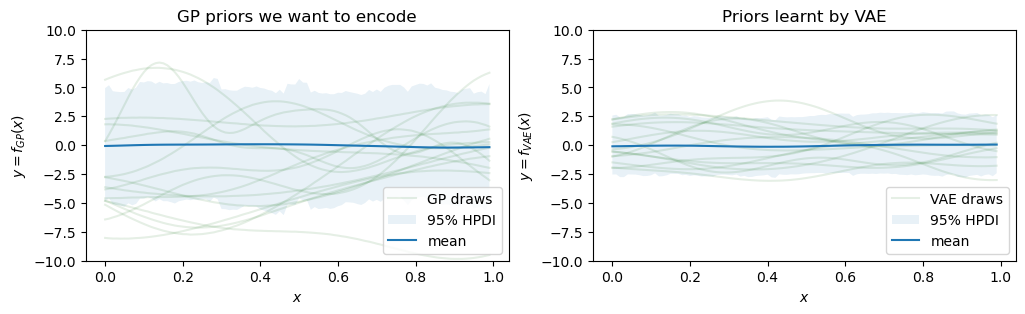

In [26]:
from reusable.vae import vae_sample
from plotting.plots import compare_draws

rng_key, rng_key_predict = random.split(random.PRNGKey(2))

plot_gp_predictive = Predictive(gp, num_samples=1000)
gp_draws = plot_gp_predictive(rng_key_predict, x=args["x"], gp_kernel = args["gp_kernel"], jitter=1e-5)['y']

plot_vae_predictive = Predictive(vae_sample, num_samples=1000)
vae_draws = plot_vae_predictive(
    rng_key_predict,
    hidden_dim1=args["hidden_dim1"],
    hidden_dim2=args["hidden_dim2"],
    latent_dim=args["latent_dim"],
    out_dim=args["n"],
    decoder_params=args["decoder_params"],
)["f"]

compare_draws(args["x"], gp_draws, vae_draws, "GP priors we want to encode", "Priors learnt by VAE", '$y=f_{GP}(x)$', '$y=f_{VAE}(x)$', "GP", "VAE", save_path="gen_plots/01_prior_comp.png", _min=-10, _max=10)


# Inference

In [27]:
from reusable.mcmc import vae_mcmc, run_mcmc

gp = BuildGP(
    args["gp_kernel"],
    noise=True,
    length_prior_choice=args["length_prior_choice"],
    length_prior_args=args["length_prior_arguments"],
    variance_prior_choice=args["variance_prior_choice"],
    variance_prior_args=args["variance_prior_arguments"],
)

rng_key_ground_truth = random.PRNGKey(
    1
)  # fixed to generate a "ground truth" GP we will try and infer

ground_truth_predictive = Predictive(gp, num_samples=1)
gt_draws = ground_truth_predictive(
    rng_key_ground_truth, x=args["x"], gp_kernel=args["gp_kernel"]
)
ground_truth = gt_draws["f"].T
ground_truth_y_draw = gt_draws["y"].T


x_obs_lst = []
y_obs_lst = []
predictions_lst = []

obs_idx_lst = [[22, 50], [16, 33, 57, 96], [8, 24, 45, 61, 77, 84]]



rng_key, rng_key_prior, rng_key_post, rng_key_pred = random.split(rng_key, 4)

for i in range(len(obs_idx_lst)):
    obs_idx = jnp.array(obs_idx_lst[i])

    y_obs = ground_truth_y_draw[obs_idx, 0]
    x_obs = args["x"][obs_idx]

    v = vae_mcmc(args["hidden_dim1"],
        args["hidden_dim2"],
        args["latent_dim"],
        args["decoder_params"],
        obs_idx)
    # inference
    mcmc_samples = run_mcmc(args["num_warmup"], args["num_samples"], args["num_chains"], rng_key_post, v, {"x": args["x"], "y": y_obs}, max_run_length=None)

    predictive = Predictive(v, mcmc_samples)
    predictions = predictive(
        rng_key_pred,
        x=args["x"]
    )["f"]

    x_obs_lst.append(x_obs)
    y_obs_lst.append(y_obs)
    obs_idx_lst.append(obs_idx)
    predictions_lst.append(predictions)





  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Done MCMC warmup run 1/1


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Done MCMC run 1/1

MCMC elapsed time: 8.584725856781006


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Done MCMC warmup run 1/1


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Done MCMC run 1/1

MCMC elapsed time: 8.9137442111969


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Done MCMC warmup run 1/1


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Done MCMC run 1/1

MCMC elapsed time: 8.87999963760376


In [28]:
prior_predictive = Predictive(vae_sample, num_samples=10000)
prior_predictions = prior_predictive(rng_key_prior,  hidden_dim1=args["hidden_dim1"],
        hidden_dim2=args["hidden_dim2"],
        latent_dim=args["latent_dim"],
        out_dim=args["n"],
        decoder_params=args["decoder_params"])["f"]



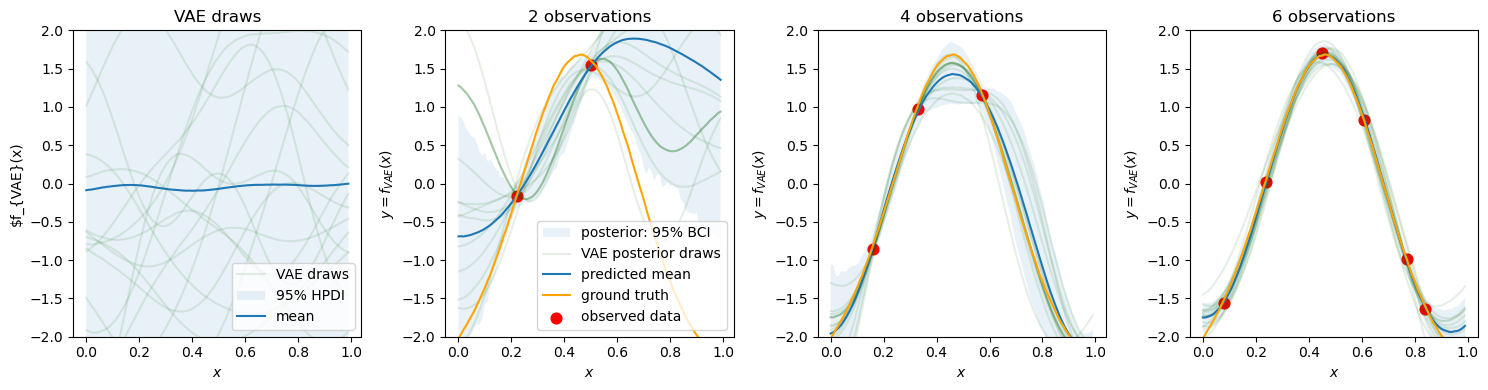

In [29]:
from plotting.plots import compare_inference_steps


compare_inference_steps(
    args["x"],
    ground_truth,
    x_obs_lst,
    y_obs_lst,
    prior_predictions,
    predictions_lst,
    title="VAE",
    save_path="gen_plots/02/" + gen_file_name("02", args, "inference_steps.png"),
)


## Covariance matrices

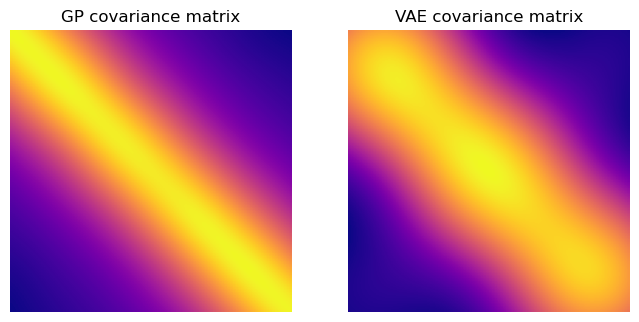

In [13]:
from plotting.plots import plot_cov_mat
import matplotlib.pyplot as plt

rng_key, rng_key_predict = random.split(random.PRNGKey(6))

gp_predictive = Predictive(OneDGP, num_samples=10000)
gp_draws = gp_predictive(rng_key_predict, x=args["x"], gp_kernel = args["gp_kernel"], jitter=1e-5)['y']

vae_predictive = Predictive(vae_sample, num_samples=10000)

vae_draws = vae_predictive(
    rng_key_predict,
    hidden_dim1=args["hidden_dim1"],
    hidden_dim2=args["hidden_dim2"],
    latent_dim=args["latent_dim"],
    out_dim=args["n"],
    decoder_params=args["decoder_params"],
)["f"]
#vae_draws[~np.isnan(gp_draws).any(axis=1), :]



fig, axs = plt.subplots(nrows=1, ncols=2, figsize = (8,4))

plot_cov_mat(gp_draws, "GP covariance matrix", axs[0])
plot_cov_mat(vae_draws, "VAE covariance matrix", axs[1])




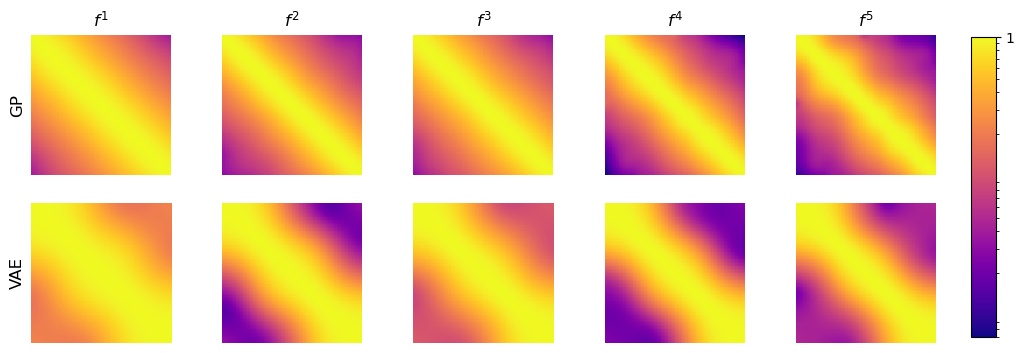

In [21]:
from plotting.plots import plot_correlation_grid


fig = plot_correlation_grid(gp_draws, vae_draws)

fig.savefig(f"gen_plots/02/" + gen_file_name("02", args, "correlations.png"), bbox_inches="tight", dpi=600)

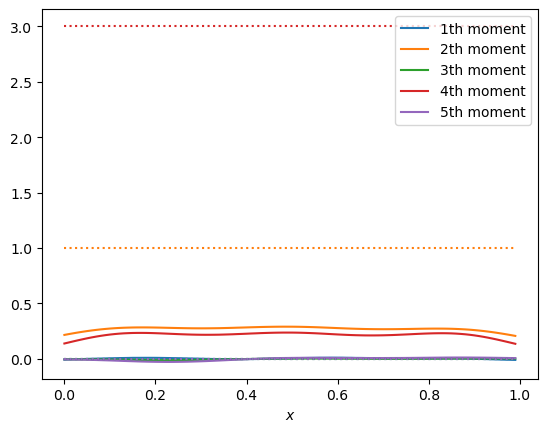

In [15]:
from reusable.moments import sample_central_moment
from plotting.plots import plot_moments

moments_compare = [1,2,3,4,5]

vae_moments = [sample_central_moment(i, vae_draws) for i in moments_compare]
#gp_moments =

gp_moments = [
    jnp.zeros_like(args["x"]),
    jnp.ones_like(args["x"]),
    jnp.zeros_like(args["x"]),
    jnp.repeat(jnp.mean(sample_central_moment(4, gp_draws)), args["n"]),
    jnp.zeros_like(args["x"])
]
plot_moments(vae_moments, moments_compare, args["x"], None, correct_moments=gp_moments, use_legend=True, save_path=f"gen_plots/02/" + gen_file_name("02", args, "moments.png"))
        